In [2]:
import time

import matplotlib.pyplot as plt
from pytorch_lightning.metrics.functional import accuracy, precision_recall, f1
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from model import GarbageModel
from util import make_ensemble, time_to_string

In [78]:
model_paths = [
    "logs_old/version_0/checkpoints/epoch=199-step=23599.ckpt",
    "logs_old/version_4/checkpoints/epoch=199-step=11799.ckpt",
    "logs_norm/version_3/checkpoints/epoch=199-step=11799.ckpt",
    "logs_norm/version_6/checkpoints/epoch=199-step=11799.ckpt",
    "logs_norm/version_7/checkpoints/epoch=199-step=11799.ckpt",
    "logs_norm/version_8/checkpoints/epoch=199-step=11799.ckpt",
    "logs_norm/version_9/checkpoints/epoch=199-step=11799.ckpt",
]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device : {}".format(device))
model = make_ensemble(model_paths, GarbageModel, device)

Device : cuda:0
 * Loading ensemble ...
Adding logs_old/version_0/checkpoints/epoch=199-step=23599.ckpt
Adding logs_old/version_4/checkpoints/epoch=199-step=11799.ckpt
Adding logs_norm/version_3/checkpoints/epoch=199-step=11799.ckpt
Adding logs_norm/version_6/checkpoints/epoch=199-step=11799.ckpt
Adding logs_norm/version_7/checkpoints/epoch=199-step=11799.ckpt
Adding logs_norm/version_8/checkpoints/epoch=199-step=11799.ckpt
Adding logs_norm/version_9/checkpoints/epoch=199-step=11799.ckpt
Categories : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Input Size : 224
 * Ensemble loaded.


In [98]:
root = "data/test448"
batch_size = 32
use_crops = True

if use_crops:
    valid_transform = T.Compose([
        T.Resize(int(1.1*model.input_size)),
        T.FiveCrop(model.input_size),
        # T.TenCrop(model.input_size),
        T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops])),
    ])
else:
    valid_transform = T.Compose([
        T.Resize(model.input_size),
        T.CenterCrop(model.input_size),
        T.ToTensor(),
    ])

valid_ds = ImageFolder(root=root, transform=valid_transform)
num_classes = len(valid_ds.classes)
val_loader = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, num_workers=0)
print("{} Test Samples.".format(len(valid_ds)))

720 Test Samples.


In [99]:
yhats = []  # All model predictions
ensemble = []  # Mean prediction
targets = []  # Targets
t0 = time.time()
for i, (data, target) in enumerate(val_loader):
    data = data.to(device)

    if use_crops:
        bs, ncrops, c, h, w = data.size()
        data = data.view(-1, c, h, w)
        with torch.no_grad():
            ymodels = [torch.softmax(m(data.clone()), dim=1).view(bs, ncrops, -1).mean(1) for m in model.models]
        avg_pred = torch.mean(torch.stack(ymodels), dim=0)
        yhat = torch.stack([torch.argmax(y, dim=1) for y in ymodels])
    else:
        with torch.no_grad():
            ymodels = [torch.softmax(m(data.clone()), dim=1) for m in model.models]
        avg_pred = torch.mean(torch.stack(ymodels), dim=0)
        yhat = torch.stack([torch.argmax(y, dim=1) for y in ymodels])

    yhats.append(yhat)
    ensemble.append(avg_pred)
    targets.append(target)
    if i%max(1, int(len(valid_ds)/(batch_size*10)))==0:
        c = len(targets)*batch_size
        duration = time.time()-t0
        remaining = duration/c * (len(valid_ds)-c)
        print("image {}/{}. {:.1f} images/second. elapsed={}. remaining={}.".format(c, len(valid_ds), c/duration, time_to_string(duration), time_to_string(remaining)))

preds = torch.cat(yhats, dim=1).cpu()
pred = torch.argmax(torch.cat(ensemble), dim=1).cpu()
target = torch.cat(targets).cpu()

c = len(target)
duration = time.time()-t0
remaining = duration/c * (len(valid_ds)-c)
print("image {}/{}. {:.1f} images/second. elapsed={}.".format(c, len(valid_ds), c/duration, time_to_string(duration)))

print("preds.shape :", preds.shape)
print("pred.shape :", pred.shape)
print("target.shape :", target.shape)


image 32/720. 35.7 images/second. elapsed=0.90 seconds. remaining=19.26 seconds.
image 96/720. 38.0 images/second. elapsed=2.52 seconds. remaining=16.41 seconds.
image 160/720. 38.0 images/second. elapsed=4.21 seconds. remaining=14.72 seconds.
image 224/720. 38.2 images/second. elapsed=5.86 seconds. remaining=12.97 seconds.
image 288/720. 38.3 images/second. elapsed=7.51 seconds. remaining=11.27 seconds.
image 352/720. 38.1 images/second. elapsed=9.25 seconds. remaining=9.67 seconds.
image 416/720. 38.1 images/second. elapsed=10.91 seconds. remaining=7.97 seconds.
image 480/720. 38.2 images/second. elapsed=12.57 seconds. remaining=6.29 seconds.
image 544/720. 38.2 images/second. elapsed=14.24 seconds. remaining=4.61 seconds.
image 608/720. 38.1 images/second. elapsed=15.97 seconds. remaining=2.94 seconds.
image 672/720. 38.0 images/second. elapsed=17.70 seconds. remaining=1.26 seconds.
image 736/720. 38.8 images/second. elapsed=18.99 seconds. remaining=-0.41 seconds.
image 720/720. 37.

In [101]:
def stats(pred, target):
    acc = accuracy(pred, target)
    avg_precision, avg_recall = precision_recall(pred, target, num_classes=num_classes, average="macro", mdmc_average="global")
    weighted_f1 = f1(pred, target, num_classes=num_classes, threshold=0.5, average="weighted")
    return 100*acc, 100*avg_precision, 100*avg_recall, 100*weighted_f1

archs = [m.hparams.model for m in model.models]
headers = ["Model", "Arch", "Accuracy", "Precision", "Recall", "F1 Score"]
aw = max(len(n) for n in archs)
width = max(len(n) for n in headers)
head_fmt = '{:>{hw}s}' + ' {:>{aw}s}' + ' {:>{hw}s}'*(len(headers)-2) + '\n'
row_fmt = '{:>{hw}s}' + ' {:>{aw}s}' + ' {:>9.2f}'*(len(headers)-2) + '\n'
stat_str = head_fmt.format(*headers, hw=hw, aw=aw)
for i in range(len(model.models)):
    row = stats(preds[i, :], target)
    stat_str += row_fmt.format(str(i), str(archs[i]),*row, hw=hw, aw=aw)
row = stats(pred, target)
stat_str += row_fmt.format("Ensemble", "", *row, hw=hw, aw=aw)
print(stat_str)

    Model               Arch  Accuracy Precision    Recall  F1 Score
        0           resnet18     94.31     94.42     94.31     94.27
        1 mobilenet_v3_large     88.61     88.99     88.61     88.47
        2 mobilenet_v3_small     93.89     93.97     93.89     93.87
        3 shufflenet_v2_x0_5     94.17     94.26     94.17     94.13
        4 shufflenet_v2_x1_0     95.83     95.91     95.83     95.83
        5 shufflenet_v2_x1_5     95.97     96.07     95.97     95.97
        6 shufflenet_v2_x2_0     95.83     95.94     95.83     95.83
 Ensemble                        96.25     96.35     96.25     96.22



In [108]:
print( classification_report(target, pred, target_names=model.classes, digits=4) )

              precision    recall  f1-score   support

   cardboard     0.9833    0.9833    0.9833       120
       glass     0.9231    1.0000    0.9600       120
       metal     0.9669    0.9750    0.9710       120
       paper     0.9524    1.0000    0.9756       120
     plastic     0.9643    0.9000    0.9310       120
       trash     0.9910    0.9167    0.9524       120

    accuracy                         0.9625       720
   macro avg     0.9635    0.9625    0.9622       720
weighted avg     0.9635    0.9625    0.9622       720



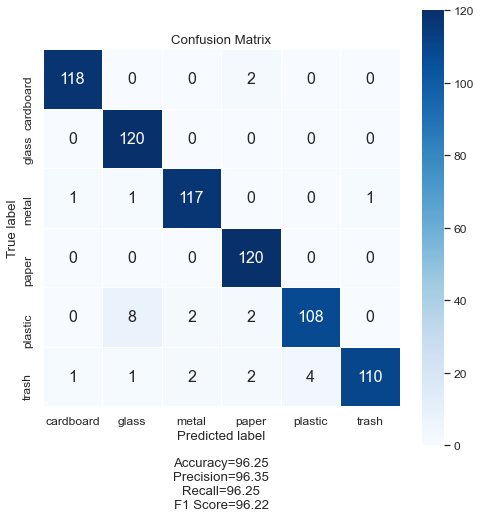

In [107]:
cm = confusion_matrix(target, pred)
plt.figure(figsize=(8, 8))
sn.set(font_scale=1.1)  # Label size
sn.heatmap(cm, annot=True, fmt="d",
cmap='Blues',
# cbar=False,
vmin=0,
xticklabels=model.classes,  yticklabels=model.classes, annot_kws={"size": 16}, square=True, linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label\n\nAccuracy={:.2f}\nPrecision={:.2f}\nRecall={:.2f}\nF1 Score={:.2f}'.format(*row))
plt.savefig('data/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()